# Bitcoin Price Prediction with LSTM

## Objective

Long Short-Term Memory networks, or LSTMs for short, can be applied to time series forecasting.

There are many types of LSTM models that can be used for each specific type of time series forecasting problem.

In this project, I will discover how to develop LSTM models for a Bitcoin price time series forecasting problems.


In [37]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "notebook_connected"
#
from yahoofinancials import YahooFinancials
#
import warnings
warnings.filterwarnings('ignore')

### I used Yahoo Financial API to get Bitcoin historical data

In [38]:
yahoo_financials = YahooFinancials('BTC-USD')
btc_data = yahoo_financials.get_historical_price_data("2016-01-01", "2023-03-31", "daily")
btc_data = btc_data['BTC-USD']['prices']
btc_data = pd.DataFrame(btc_data)
btc_data.head()

,date,high,low,open,close,volume,adjclose,formatted_date
0,1451606400,436.246002,427.515015,430.721008,434.334015,36278900,434.334015,2016-01-01
1,1451692800,436.062012,431.869995,434.622009,433.437988,30096600,433.437988,2016-01-02
2,1451779200,433.743011,424.705994,433.578003,430.010986,39633800,430.010986,2016-01-03
3,1451865600,434.516998,429.084015,430.061005,433.091003,38477500,433.091003,2016-01-04
4,1451952000,434.182007,429.675995,433.069000,431.959991,34522600,431.959991,2016-01-05


# Data Description :
## Start date : 2016-01-01 , End date : 2023-03-31
### Columns :
- date 
- high -> Highest price of the day
- low -> Lowest price of the day
- open -> Opening price of Market 
- close -> Market close price
- volume -> Volume of transactions per day
- adjclose -> Adjusted price at end of day


In [39]:
btc_data['date'] = btc_data['formatted_date']
btc_data.drop('formatted_date', axis=1, inplace=True)

In [40]:
btc_data.head()

,date,high,low,open,close,volume,adjclose
0,2016-01-01,436.246002,427.515015,430.721008,434.334015,36278900,434.334015
1,2016-01-02,436.062012,431.869995,434.622009,433.437988,30096600,433.437988
2,2016-01-03,433.743011,424.705994,433.578003,430.010986,39633800,430.010986
3,2016-01-04,434.516998,429.084015,430.061005,433.091003,38477500,433.091003
4,2016-01-05,434.182007,429.675995,433.069000,431.959991,34522600,431.959991


In [41]:
btc_data.tail()

,date,high,low,open,close,volume,adjclose
2642,2023-03-27,28037.925781,26606.689453,27994.068359,27139.888672,18188895178,27139.888672
2643,2023-03-28,27460.718750,26677.818359,27132.888672,27268.130859,17783600385,27268.130859
2644,2023-03-29,28619.542969,27259.662109,27267.031250,28348.441406,20684945906,28348.441406
2645,2023-03-30,29159.902344,27720.160156,28350.140625,28033.562500,22435349951,28033.562500
2646,2023-03-31,28639.896484,27583.714844,28032.261719,28478.484375,19001327598,28478.484375


In [42]:
btc = btc_data.iloc[-7:,:-1].round()
btc.to_csv('btc.csv', index=False)

In [43]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2647 entries, 0 to 2646
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      2647 non-null   object 
 1   high      2647 non-null   float64
 2   low       2647 non-null   float64
 3   open      2647 non-null   float64
 4   close     2647 non-null   float64
 5   volume    2647 non-null   int64  
 6   adjclose  2647 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 144.9+ KB


In [44]:
btc_data.describe().round(2)

,high,low,open,close,volume,adjclose
count,2647.00,2647.00,2647.00,2647.00,2.647000e+03,2647.00
mean,15817.21,15004.70,15430.41,15439.22,1.955893e+10,15439.22
std,16814.45,15911.27,16394.99,16390.62,2.011474e+10,16390.62
min,374.95,354.91,365.07,364.33,2.851400e+07,364.33
25%,3910.75,3727.42,3840.81,3846.19,2.763655e+09,3846.19
50%,9142.28,8704.99,8901.95,8897.47,1.652272e+10,8897.47
75%,21610.63,20777.16,21185.44,21210.99,3.095508e+10,21210.99
max,68789.62,66382.06,67549.73,67566.83,3.509679e+11,67566.83


# Data Preproccessing

In [45]:
btc_data['date'] = pd.to_datetime(btc_data['date'])
btc_data['date'] = btc_data['date'].values.astype('datetime64[D]')
print('Date format : ', btc_data['date'].dtypes)

Date format :  datetime64[ns]


#### Checking close and adjclose columns 

In [46]:
(btc_data['close']!=btc_data['adjclose']).sum()

0

In [47]:
# close and adjclose columns is equal, so drop the adjclose columns
btc_data.drop('adjclose', axis=1, inplace=True)

#### Checking for Null Values

In [48]:
print('null data', btc_data.isnull().sum())

null data date      0
high      0
low       0
open      0
close     0
volume    0
dtype: int64


In [49]:
print('NA data :', btc_data.isna().values.any())

NA data : False


# EDA(Exploratory Data Analysis)

In [50]:
start = btc_data.date.min()
end = btc_data.date.max()
print(f'Price date range : {(start, end)}')

Price date range : (Timestamp('2016-01-01 00:00:00'), Timestamp('2023-03-31 00:00:00'))


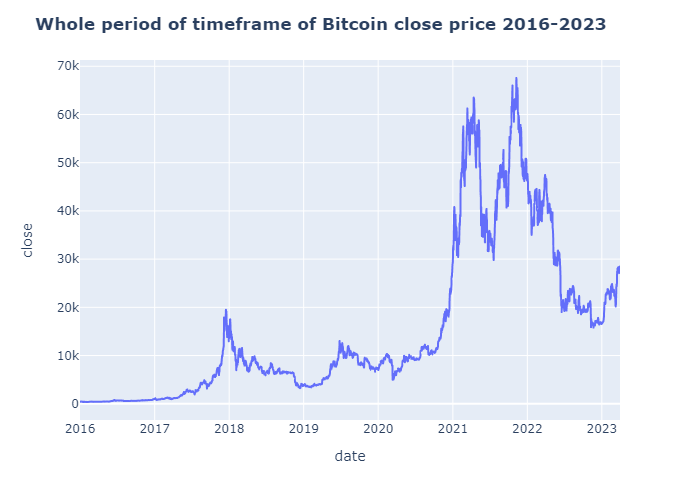

In [51]:
figure = px.line(btc_data, x='date', y='close')
figure.update_layout(title='<b>Whole period of timeframe of Bitcoin close price 2016-2023<b>')
figure.show('png')

In [52]:
agg_data = btc_data.copy()
agg_data['month'] = agg_data['date'].dt.strftime('%B').str[:3]
agg_data['month_num'] = agg_data['date'].dt.month
agg_data['year'] = agg_data['date'].dt.year

In [53]:
agg_data.head(2)

,date,high,low,open,close,volume,month,month_num,year
0,2016-01-01,436.246002,427.515015,430.721008,434.334015,36278900,Jan,1,2016
1,2016-01-02,436.062012,431.869995,434.622009,433.437988,30096600,Jan,1,2016


In [54]:
yel = '#f1ba0b'
darkb='#46505f'
gray='#a5a5a5'
drgray='#73848e'
salem='#c49b9c'

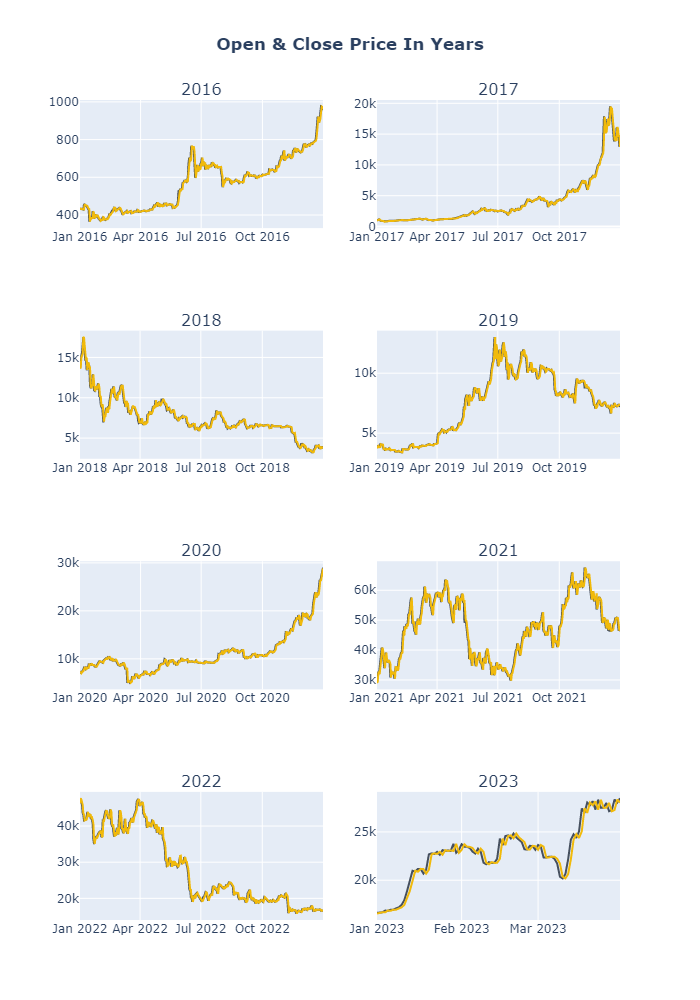

In [55]:
rows = [1,1,2,2,3,3,4,4]
cols=[1,2]*4
subplot_titles = ['2016','2017', '2018','2019','2020','2021','2022', '2023']
fig = make_subplots(rows=4, cols=2, subplot_titles=subplot_titles)

for y ,i, j in zip(agg_data.year.unique(),rows,cols) :
    yearly_data = agg_data[agg_data.year==y]
    fig.add_trace(go.Scatter(x=yearly_data.date, y=yearly_data['close'], name="open",mode='lines', line=dict(color=darkb, width=2), ), row=i, col=j)
    fig.add_trace(go.Scatter(x=yearly_data.date, y=yearly_data['open'], name='Close',mode='lines',line=dict(color=yel, width=2)), row=i, col=j)

fig.update_layout(title='<b>Open & Close Price In Years<b>', title_x=0.5, height=1000, showlegend=False)
fig.show('png')

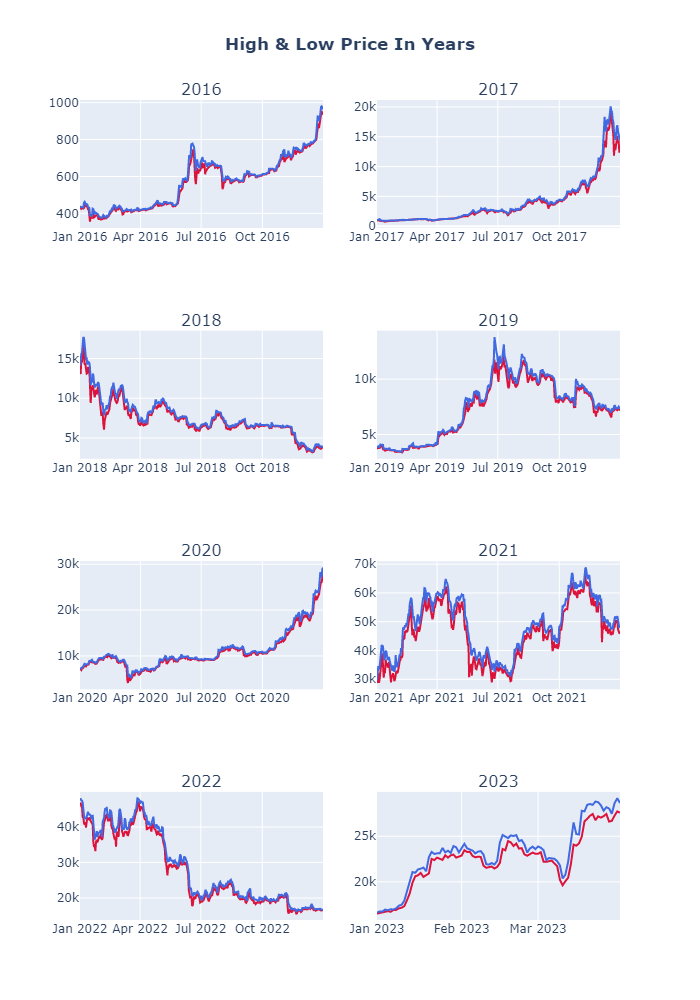

In [56]:
rows = [1,1,2,2,3,3,4,4]
cols=[1,2]*4
subplot_titles = ['2016','2017', '2018','2019','2020','2021','2022', '2023']
fig = make_subplots(rows=4, cols=2, subplot_titles=subplot_titles)

for y ,i, j in zip(agg_data.year.unique(),rows,cols) :
    yearly_data = agg_data[agg_data.year==y]
    fig.add_trace(go.Scatter(x=yearly_data.date, y=yearly_data['low'], name=str(y),mode='lines', line=dict(color='crimson', width=2)), row=i, col=j)
    fig.add_trace(go.Scatter(x=yearly_data.date, y=yearly_data['high'], name=str(y),mode='lines',line=dict(color='royalblue', width=2)), row=i, col=j)

fig.update_layout(title='<b>High & Low Price In Years<b>', title_x=0.5, height=1000, showlegend=False)
fig.show('png')

### Open & Close Price Monthly

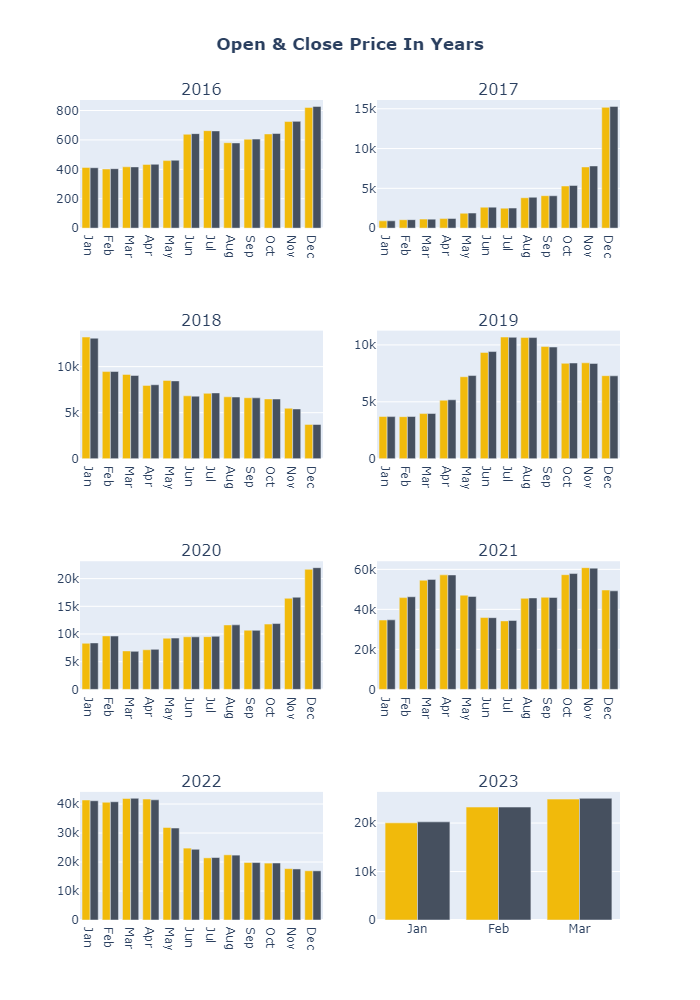

In [57]:
rows = [1,1,2,2,3,3,4,4]
cols=[1,2]*4
subplot_titles = ['2016','2017', '2018','2019','2020','2021','2022', '2023']
fig = make_subplots(rows=4, cols=2, subplot_titles=subplot_titles)

for y ,i, j in zip(agg_data.year.unique(),rows,cols) :
    yearly_data = agg_data[agg_data.year==y]
    year_agg = yearly_data.groupby(['month','month_num']).mean()
    year_agg.sort_index(level=1, inplace=True)
    year_agg = year_agg.droplevel(1)
    fig.add_trace(go.Bar(x=year_agg.index, y=year_agg['open'], name="open",  marker_color=yel), row=i, col=j)
    fig.add_trace(go.Bar(x=year_agg.index, y=year_agg['close'], name='Close', marker_color=darkb), row=i, col=j)


fig.update_layout(title='<b>Open & Close Price In Years<b>', title_x=0.5, height=1000, showlegend=False)
fig.show('png')

### Low & High Price Monthly

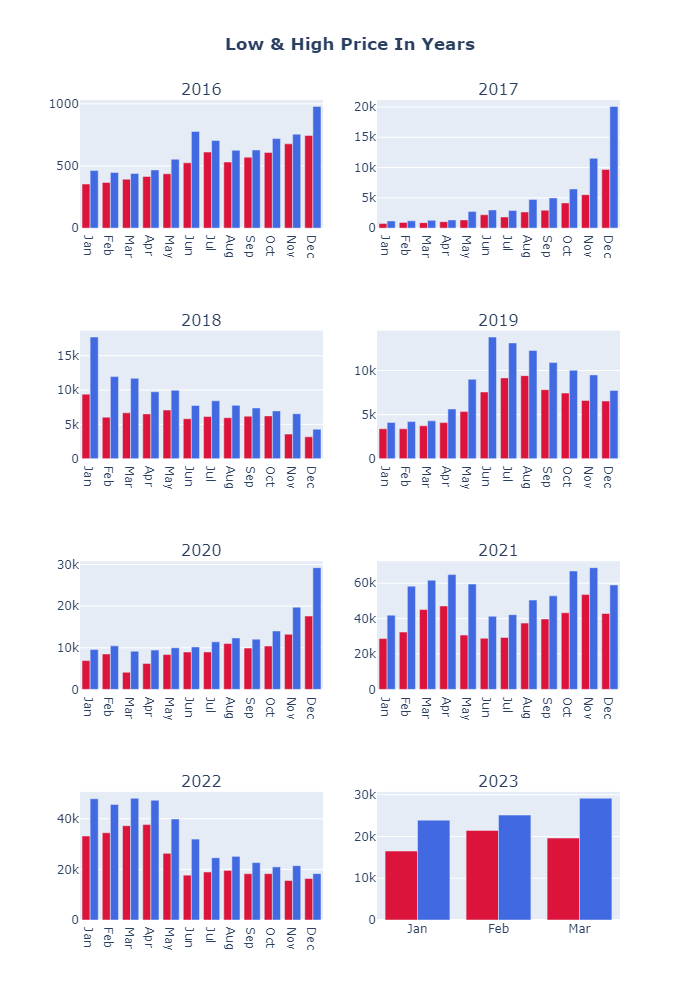

In [58]:
rows = [1,1,2,2,3,3,4,4]
cols=[1,2]*4
subplot_titles = ['2016','2017', '2018','2019','2020','2021','2022', '2023']
fig = make_subplots(rows=4, cols=2, subplot_titles=subplot_titles)

for y ,i, j in zip(agg_data.year.unique(),rows,cols) :
    yearly_data = agg_data[agg_data.year==y]
    year_agg = yearly_data.groupby(['month','month_num']).agg({'low':'min', 'high':'max'})
    year_agg.sort_index(level=1, inplace=True)
    year_agg = year_agg.droplevel(1)
    fig.add_trace(go.Bar(x=year_agg.index, y=year_agg['low'], name=str(y), marker_color='crimson'), row=i, col=j)
    fig.add_trace(go.Bar(x=year_agg.index, y=year_agg['high'], name=str(y),  marker_color='royalblue'), row=i, col=j)

fig.update_layout(title='<b>Low & High Price In Years<b>', title_x=0.5, height=1000, showlegend=False)
fig.show('png')

#### Price & Volume

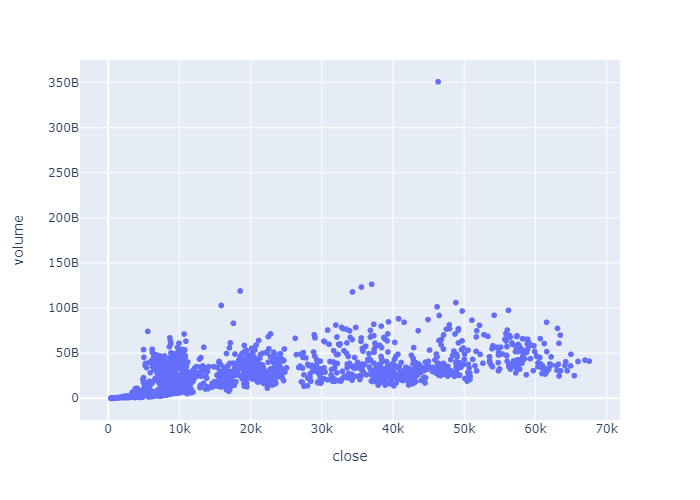

In [59]:
figure = px.scatter(btc_data, x='close', y='volume')
figure.show('png')

# Building LSTM Model

#### we are just considering 2 year data for training data
- As we want to predict Close Price of the Bitcoin so we are just Considering Close and Date

In [60]:
data = btc_data[['date', 'close']]
data = data[data.date.dt.year>2020]
data


,date,close
1827,2021-01-01,29374.152344
1828,2021-01-02,32127.267578
1829,2021-01-03,32782.023438
1830,2021-01-04,31971.914062
1831,2021-01-05,33992.429688
...,...,...
2642,2023-03-27,27139.888672
2643,2023-03-28,27268.130859
2644,2023-03-29,28348.441406
2645,2023-03-30,28033.562500


In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.metrics import accuracy_score, r2_score 
from sklearn.preprocessing import MinMaxScaler
#
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

#### Train, Test Split

In [62]:
def train_test_split(data, train_size):
    train_s = int(len(data)*train_size)
    test_size = len(data)-train_s
    train = data.iloc[:train_s, :]
    test = data.iloc[train_s:, :]
    del train['date']
    del test['date']
    return train, test

In [63]:
train_size = int(len(data)*0.8)
test_size = len(data)-train_size
print(f'Train size : {train_size}\n Test Size : {test_size}')

Train size : 656
 Test Size : 164


In [64]:
train = data.iloc[:train_size, :]
test = data.iloc[train_size:,:]
del train['date']
del test['date']

#### Scaling

In [65]:
scaler = MinMaxScaler(feature_range=(0,1))
scl_train = scaler.fit_transform(train)
scl_test = scaler.transform(test)

#### Create sequence

In [66]:
def create_sequence(data, step):
    X, Y = [], []
    for i in range(len(data)-step-1):
        x = data[i:(i+step), 0]
        y = data[(i+step), 0]
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)

In [67]:
look_back = 2
x_train, y_train = create_sequence(scl_train, look_back)
x_test, y_test = create_sequence(scl_test, look_back)

In [68]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test", y_test.shape)

x_train:  (653, 2)
y_train:  (653,)
x_test:  (161, 2)
y_test (161,)


#### Reshape to 3D for LSTM

In [69]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
print("X_train: ", x_train.shape)
print("X_test: ", x_test.shape)

X_train:  (653, 2, 1)
X_test:  (161, 2, 1)


# LSTM

In [70]:
lstm = Sequential()
lstm.add(LSTM(100, input_shape=(x_train.shape[1], x_train.shape[2]), activation="relu"))
lstm.add(Dense(1))
lstm.compile(loss="mean_squared_error", optimizer="adam", metrics='RootMeanSquaredError')

In [71]:
hist = lstm.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=30, verbose=0, shuffle=False)

In [72]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = list(range(len(loss)))

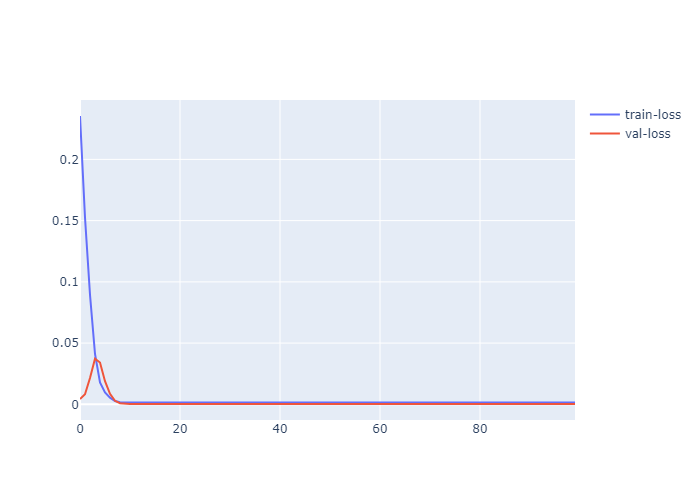

In [73]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=epochs, y=loss, name='train-loss'))
fig.add_trace(go.Scatter(x=epochs, y=val_loss, name='val-loss'))
fig.show('png')

In [74]:
y_train_pred = lstm.predict(x_train)
y_pred = lstm.predict(x_test)
inv_y_train_pred = scaler.inverse_transform(y_train_pred)
inv_y_pred = scaler.inverse_transform(y_pred)

#### Compare RMSE for Train and Test

In [75]:
org_y_train = scaler.inverse_transform(y_train.reshape(-1,1))
org_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

In [76]:
print(f'Train RMSE : {round(np.sqrt(mean_squared_error(org_y_train, inv_y_train_pred)),2)}')
print(f'Test RMSE : {round(np.sqrt(mean_squared_error(org_y_test, inv_y_pred)),2)}')

Train RMSE : 2069.73
Test RMSE : 857.86


In [77]:
print(f'Train MAE : {round(mean_absolute_error(org_y_train, inv_y_train_pred),2)}')
print(f'Test MAE : {round(mean_absolute_error(org_y_test, inv_y_pred),2)}')

Train MAE : 1576.79
Test MAE : 577.88


In [78]:
print("Train data R2 score:", r2_score(org_y_train, inv_y_train_pred))
print("Test data R2 score:", r2_score(org_y_test, inv_y_pred))

Train data R2 score: 0.9736799498083326
Test data R2 score: 0.9419577893628078


In [79]:
train_data = data.iloc[look_back:len(org_y_train)+look_back,:]
test_data = data.iloc[train_size:,:]
train_data['train_pred'] = inv_y_train_pred
nan_array = np.empty_like(test_data)
nan_array[:,:]=np.nan
test_data['test_pred'] = nan_array[:,0]
test_data['test_pred'].iloc[-len(inv_y_pred):] = inv_y_pred.reshape(-1)

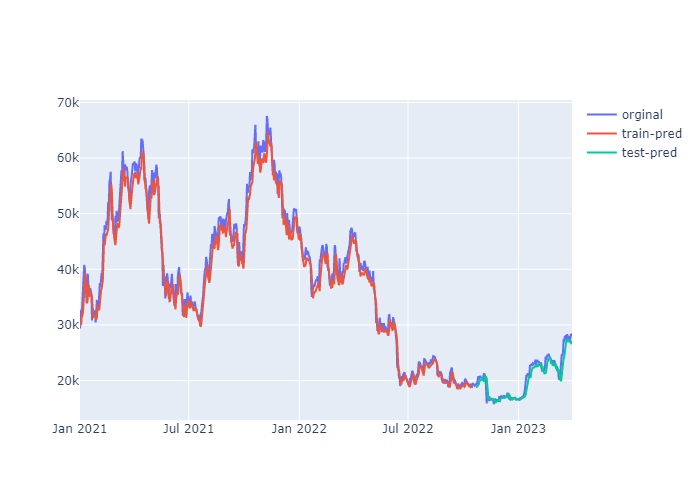

In [80]:
fig =go.Figure()
fig.add_trace(go.Scatter(x=data['date'], y=data['close'], name='orginal'))
fig.add_trace(go.Scatter(x=train_data['date'], y=train_data['train_pred'], name='train-pred'))
fig.add_trace(go.Scatter(x=test_data['date'], y=test_data['test_pred'], name='test-pred'))
fig.show('png')

# Try with add Volume column as new feature 

In [81]:
data = btc_data[['date', 'volume','close']]
data = data[data.date.dt.year>2020]
data

,date,volume,close
1827,2021-01-01,40730301359,29374.152344
1828,2021-01-02,67865420765,32127.267578
1829,2021-01-03,78665235202,32782.023438
1830,2021-01-04,81163475344,31971.914062
1831,2021-01-05,67547324782,33992.429688
...,...,...,...
2642,2023-03-27,18188895178,27139.888672
2643,2023-03-28,17783600385,27268.130859
2644,2023-03-29,20684945906,28348.441406
2645,2023-03-30,22435349951,28033.562500


In [82]:
train, test = train_test_split(data, 0.8)

In [83]:
print(f'Train data shape : {train.shape}\n Test data shape : {test.shape}')

Train data shape : (656, 2)
 Test data shape : (164, 2)


In [84]:
scaler = MinMaxScaler(feature_range=(0,1))
scl_train = scaler.fit_transform(train)
scl_test = scaler.transform(test)

In [85]:
def series_to_seq(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [86]:
seq_train = series_to_seq(scl_train, 1, 1)
seq_test = series_to_seq(scl_test, 1, 1)

In [87]:
seq_train.head(3)

,var1(t-1),var2(t-1),var1(t),var2(t)
1,0.080045,0.220867,0.160510,0.277030
2,0.160510,0.277030,0.192535,0.290387
3,0.192535,0.290387,0.199943,0.273861


In [88]:
# We wil predict var2(t)
# Drop var1(t)
del seq_train['var1(t)']
del seq_test['var1(t)']

In [89]:
x_train, y_train = seq_train.iloc[:,:2].values, seq_train.iloc[:,2].values
x_test, y_test = seq_test.iloc[:,:2].values, seq_test.iloc[:,2].values

In [90]:
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

In [91]:
lstm = Sequential()
lstm.add(LSTM(100, input_shape=(x_train.shape[1], x_train.shape[2]), activation="relu"))
lstm.add(Dense(1))
lstm.compile(loss="mean_squared_error", optimizer="adam", metrics='RootMeanSquaredError')

In [92]:
hist = lstm.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=30, verbose=0, shuffle=False)

In [93]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = list(range(len(loss)))

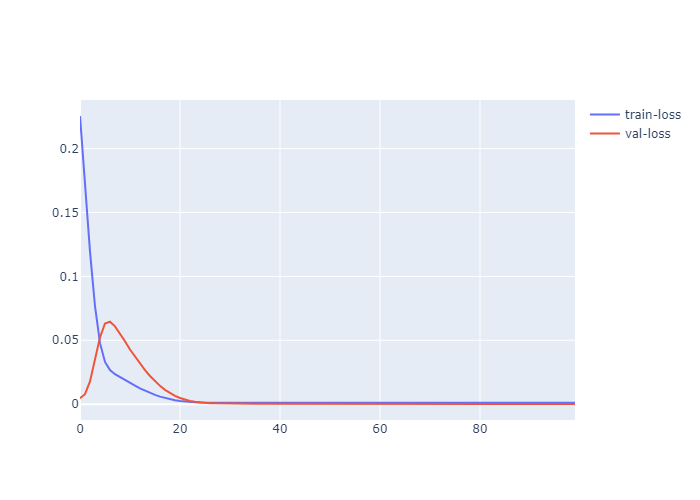

In [94]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=epochs, y=loss, name='train-loss'))
fig.add_trace(go.Scatter(x=epochs, y=val_loss, name='val-loss'))
fig.show('png')

In [95]:
y_train_pred = lstm.predict(x_train)
y_pred = lstm.predict(x_test)
# reshape
x_train = x_train.reshape((x_train.shape[0], x_train.shape[2]))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[2]))

In [96]:
scaler.get_feature_names_out()

array(['volume', 'close'], dtype=object)

#### Inverse transformed values

In [97]:
con_train = np.stack((x_train[:, 0], y_train), axis=1)
con_test = np.stack((x_test[:, 0], y_test), axis=1)
org_y_train = scaler.inverse_transform(con_train)[:,1]
org_y_test = scaler.inverse_transform(con_test)[:,1]
#
con_train_ = np.concatenate((x_train[:, 0].reshape(-1, 1), y_train_pred), axis=1)
con_test_ = np.concatenate((x_test[:, 0].reshape(-1, 1), y_pred), axis=1)
inv_y_train_pred = scaler.inverse_transform(con_train_)[:,1]
inv_y_pred = scaler.inverse_transform(con_test_)[:,1]

In [98]:
print(f'Train RMSE : {round(np.sqrt(mean_squared_error(org_y_train, inv_y_train_pred)),2)}')
print(f'Test RMSE : {round(np.sqrt(mean_squared_error(org_y_test, inv_y_pred)),2)}')

Train RMSE : 1604.34
Test RMSE : 624.37


In [99]:
print(f'Train MAE : {round(mean_absolute_error(org_y_train, inv_y_train_pred),2)}')
print(f'Test MAE : {round(mean_absolute_error(org_y_test, inv_y_pred),2)}')

Train MAE : 1119.99
Test MAE : 427.83


In [100]:
print("Train data R2 score:", r2_score(org_y_train, inv_y_train_pred))
print("Test data R2 score:", r2_score(org_y_test, inv_y_pred))

Train data R2 score: 0.9842110291229781
Test data R2 score: 0.9698340211917726


In [101]:
look_back = 1
train_data = data.iloc[look_back:len(org_y_train)+look_back,:]
test_data = data.iloc[train_size:,:]
train_data['train_pred'] = inv_y_train_pred
nan_array = np.empty_like(test_data)
nan_array[:,:]=np.nan
test_data['test_pred'] = nan_array[:,0]
test_data['test_pred'].iloc[-len(inv_y_pred):] = inv_y_pred.reshape(-1)

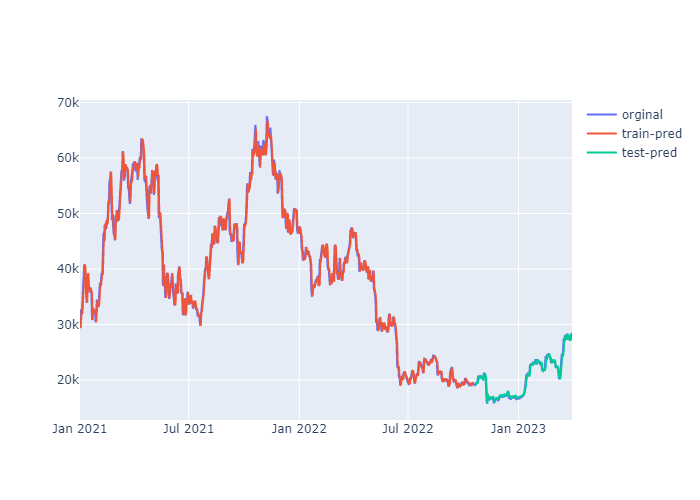

In [102]:
fig =go.Figure()
fig.add_trace(go.Scatter(x=data['date'], y=data['close'], name='orginal'))
fig.add_trace(go.Scatter(x=train_data['date'], y=train_data['train_pred'], name='train-pred'))
fig.add_trace(go.Scatter(x=test_data['date'], y=test_data['test_pred'], name='test-pred'))
fig.show('png')

# Summary & Conclusion :
By adding the volume of transactions to the model we can improve all of the metrics and model accuracy :

- first model RMSE = 857
- Second model RMSE = 640

- first model R2_Score = 0.94
- Second model R2_Score = 0.96

# Suggestions for next steps:
For improve model accurracy we can add more feature such as MA, EMA,... and more look back step in input data. also we can use AutoEncoder + LSTM approch for reduse dimentionaly and uncovering more hidden trend of data.